# 6: Restricted Boltzmann Machines

1. After the RBM has been trained, introduce a lower “temperature” in the
sigmoid function (eventually zero: deterministic system) to generate the
hidden layer and the visible fantasy data.
2. Check if the method at point 1 yields the closest category to each data
sample, which ideally is its original category (“0”,”1”,”2”,”3”) before
random corruption of bits. An estimate of the fracton of correct category
recovery can be performed either with the method provided during the
lecture or by writing on file the true label y during data generation and by
reading it during the check.
3. Introduce a fifth state “4” (see table below) and check which is the minimum number of hidden
units M for the RBM to work properly. Eventually repeat this also when a sixth state “5” is
introduced.
4. If there is time, repeat the above points for systems with larger error rate (q>0.1) and for
systems with larger block rate (Z>2, so that L=4*Z>8). For example, for Z=3 one has L=12 and
new states would be “4”=111111111111 and “5”=100100100000.

## Reading data and training it (following what done during lesson)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import exp

In [4]:
fname = 'dataRBM_q0,1.csv'
data = np.loadtxt(fname, delimiter=',', dtype=int)

N = len(data)
L = len(data[1])

print(f'Data len N = {N}\nDigits for wach line L = {L}')

Data len N = 10000
Digits for wach line L = 8


In [5]:
# 0 -> -1 and 1 -> 1
# Visible data
v = 2*data - 1 
# test v called v0
v0 = np.copy(v) # fix

for k in range(5):
    print(data[k], v[k])
    
# Initializing
np.random.seed(12342)

# Number of hidden units
M = 2 # as describerd in the intro, minimum number

# range of initial weight
sigma = np.sqrt( 4/(L+M) )
print(f'Sigma = {sigma}')

# initial weights (pag 98, but no gaussian)
# This example should be robust (converges
# but also because the example is simple)
w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M) # 0's !
print(f'w = \n{w}')
print(f'a = \n{a}')
print(f'b = \n{b}')

[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 1 0 0] [-1 -1  1  1 -1  1 -1 -1]
[1 0 1 1 0 1 1 1] [ 1 -1  1  1 -1  1  1  1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
Sigma = 0.6324555320336759
w = 
[[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
a = 
[-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
b = 
[0. 0.]


x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1]


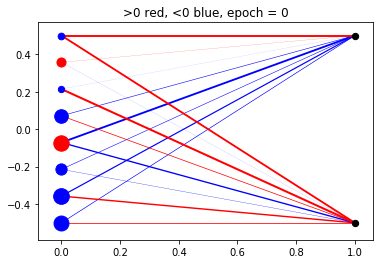

In [6]:
# For visual interpretation
def create_cord(np,x0):
    '''
    Returns the coordinates for vertically aligned layers
    np -> L or m
    x0 -> position of the layer in x axis
    '''
    x = [x0] * np
    print(f'x = {x}')
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1) - 0.5
    return (x,y)

(x1,y1) = create_cord(L,0) # visible
(x2,y2) = create_cord(M,1) # hidden

def mycolor(val):
    '''Return color w.r.t. the sign'''
    if val > 0:
        return 'red'
    elif val < 0:
        return 'blue'
    return 'black'

def plotgraph(epoch = 0):
    '''
    Display plot of the RBM's layers.
    Color represent sign while thickness of line
    represent the absolute value of the weight.
    
    epoch -> epoch of the training for label
    '''
    # Max line width = 2
    A = 2/w.max() # using weights
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]), (y1[i],y2[j]), mycolor(w[i][j])
            # zorder -> scatter plot on top of weights
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))
    
    # point size
    PS = 400
    PSmin = 40
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=max(PSmin,PS*np.abs(a[i])),
                   zorder=2, c=mycolor(a[i]))
    for i in range(M):
        plt.scatter(x2[i], y2[i], s=max(PSmin,PS*np.abs(b[i])),
                   zorder=2, c=mycolor(b[i]))
    plt.title(f'>0 red, <0 blue, epoch = {epoch}')
    plt.show()
    
    
# ----------- initial configuration
plotgraph()


## 1: Introducing a 'temperature' in the sigmoid

Here we introduce the temperature through the $\beta$ parameter in the sigmoid 
$$ \sigma (x) = \frac{1}{1 + \exp{\left[-\beta x \right]}} $$

Default $\beta = 1$. Note that if $T \rightarrow 0^+$ then $\beta \rightarrow + \infty$, which gives a sigmoid either 0, for negative $x$, or 1 for positive $x$, i.e. deterministic.

In [7]:
# Activation function
# eq (213) page 97

def activate(v_in, wei, bias, beta = 1, info=False):
    '''Returns the activated array'''
    
    # activation
    act = np.dot(v_in, wei) + bias
    prob = 1/(1+exp(-act*beta))
    n = act.shape
    # list of -1's
    v_out = -np.ones(n, dtype=int)
    # list of 1's according to prob
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print(f'input = {v_in}')
        print(f'act = {act}')
        print(f'prob = {prob}')
        print(f'output = {v_out}')
        
    return v_out


# Activation for the initial w, b and input v[0]
k = 0
activate(v[k],w,b,info=True)

input = [-1 -1  1  1 -1 -1  1  1]
act = [-1.4184683   0.61989888]
prob = [0.19490182 0.65019555]
output = [-1  1]


array([-1,  1])

------------ epoch =  1 k =  499 m =  500
dw = [[ 0.296  0.132]
 [ 0.148  0.168]
 [-0.316  0.008]
 [-0.16   0.156]
 [-0.108 -0.208]
 [-0.064 -0.268]
 [ 0.016  0.188]
 [-0.244  0.048]]
da = [ 0.192  0.244  0.164 -0.304  0.284 -0.024 -0.152  0.076]
db = [ 0.16  -0.036]
Completed epoch:  1 with l_rate =  1.0
------------ epoch =  2 k =  499 m =  500
dw = [[-0.03666667 -0.06666667]
 [-0.00333333  0.01333333]
 [-0.01333333 -0.01666667]
 [-0.04        0.09      ]
 [ 0.          0.00333333]
 [ 0.01333333 -0.00333333]
 [ 0.02333333  0.02      ]
 [-0.05333333  0.03      ]]
da = [-0.05333333 -0.07333333  0.03        0.01666667  0.02333333  0.03666667
  0.00666667  0.01666667]
db = [-0.02333333  0.00666667]
Completed epoch:  2 with l_rate =  0.8333333333333334
Completed epoch:  3 with l_rate =  0.7142857142857143
Completed epoch:  4 with l_rate =  0.625
Completed epoch:  5 with l_rate =  0.5555555555555556
Completed epoch:  6 with l_rate =  0.5
Completed epoch:  7 with l_rate =  0.454545454545454

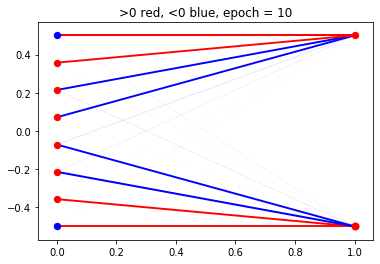

Completed epoch:  11 with l_rate =  0.3333333333333334
Completed epoch:  12 with l_rate =  0.3125000000000001
Completed epoch:  13 with l_rate =  0.29411764705882365
Completed epoch:  14 with l_rate =  0.2777777777777779
Completed epoch:  15 with l_rate =  0.2631578947368422
Completed epoch:  16 with l_rate =  0.2500000000000001
Completed epoch:  17 with l_rate =  0.2380952380952382
Completed epoch:  18 with l_rate =  0.22727272727272735
Completed epoch:  19 with l_rate =  0.21739130434782616
Completed epoch:  20 with l_rate =  0.20833333333333343


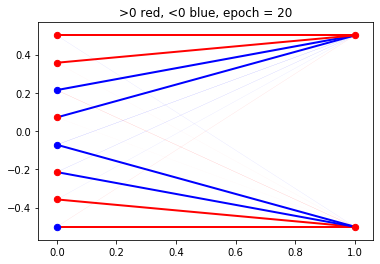

In [8]:
# Training
# learning rate
l_rate = 1.0

# Minibatch size and index m = 0, ... ,mini-1
mini, m = 500, 0
# Epochs
max_epoch = 20

# train model
for epoch in range(1,max_epoch+1):
    # changing l_rate on the fly
    l_rate_m = l_rate / mini
    
    # scan of data from the catalog
    for k in range(N):
        if m==0:
            # in the beginning of the minibatch we initialize
            # variables
            # These accumulates statistics during training
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
            
        # positive CD phase: generate h
        h = activate(v[k],w,b)
        # negative CD phase: generate fantasy vf
        vf = activate(h,w.T,a) # note the transpose
        # one more positive CD phase: generate fantasy
        # h from fantasy vf
        hf = activate(vf,w,b)
        
        # Accumulate data
        v_data += v[k]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model += np.outer(vf.T,hf)
        
        # next minibatch
        m += 1
        
        # When m == mini, we start the GD
        if m == mini:
            # gradient od the likelihood: follow it along its positive
            # diretion; Here we use the vanilla GD methos
            # Note: the normalization for the minibatch size is
            # done implicitly in l_rate_m
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)
            db = l_rate_m*(h_data - h_model)
            
            # see increments only for small values of epoch and k
            # just to see if GD is stable
            if epoch <= 2 and k <= mini:
                print('------------ epoch = ', epoch, 'k = ', k,
                     'm = ', m)
                print(f'dw = {dw}')
                print(f'da = {da}')
                print(f'db = {db}')
                
            # Basic step of vanilla GD, from eq (211)
            w = w+dw
            a = a+da
            b = b+db
            
            m = 0
    print('Completed epoch: ', epoch, 'with l_rate = ', l_rate)

    # randomize the order of input data
    np.random.shuffle(v)
    # let the learning rate deacy as epoch^-1
    # this is done the way it is done
    # we need a power law decay, not an exp one
    l_rate = l_rate / (.2 * l_rate + 1)
    
    # visualization
    if epoch%10 == 0:
        plotgraph(epoch)
            

## 2: Best temperature for denoising 

In [9]:
# v0 -> noised data

# defining a function to denoise data
# take as argument the temperature
def denoise(temp, save = False):
    '''
    Returns the number of structured data (i.e. that series which have
    a recognizable pattern) before and after the denoising by producing
    fantasy particles (the model is already trained).
    Moreover, it returns the array of denoised data
    (orininal, denoised, v1)
    '''
    
    # v1, vector in which save the denoised data
    v1 = np.zeros_like(v0)
    beta = 1./temp
    
    for k in range(N):
        # positive CD phase
        h = activate(v0[k],w,b,beta)
        # negative CD phase
        v1[k] = activate(h,w.T,a,beta)
    
    # difference betweeen fantasy and data
    # if elements are equale -> diff = 0
    # otherwise diff != 0
    diff = (v1 - v0)/2
    
    if save:
        str0 = 'M' + str(M) + '-mini' + str(mini) + fname
        np.savetxt('fant-'+str0, (v1+1)/2, fmt = '%d', delimiter=',')
        np.savetxt('diff-'+str0, diff, fmt = '%d', delimiter=',')

    Z = L//4
    vv0 = [0] * Z
    vv1 = [1] * Z
    case= (vv1 + vv0 + vv1 + vv0,
           vv0 + vv1 + vv1 + vv0,
           vv1 + vv0 + vv0 + vv1,
           vv0 + vv1 + vv0 + vv1)
    
    # Var in which save number of denoise data
    original = 0 # original for a comparison
    denoised = 0
    
    # .all() -> returns true if all elements are true
    for k in range(N):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()
        
        is0_ = (vec0==case[0]).all()
        is1_ = (vec0==case[1]).all()
        is2_ = (vec0==case[2]).all()
        is3_ = (vec0==case[3]).all()
        
        
        # if a structure is recovered, increase denoised
        if (is0 or is1 or is2 or is3):
            denoised += 1 
        # This is used to check how many pattern are recognisable
        # in the original data (note elaborated by the RBM)
        if (is0_ or is1_ or is2_ or is3_):
            original += 1
    
    return (original, denoised, v1)



# ------------- Generate different denoising as a function of the temperature T
T = [0.1, 0.5, 0.8, 1, 2, 5, 10, 100]

# List with structured data (denoised)
n_structured = []

for t in T:
    n_orig, n_den, _ = denoise(t)
    n_structured.append(n_den)

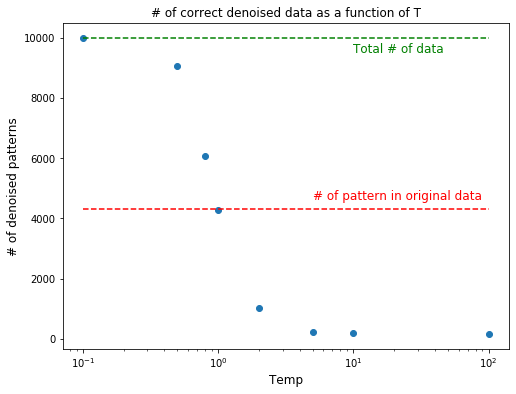

In [10]:
# Plotting
plt.figure(figsize=(8,6))

fsize = 12
plt.plot(T, n_structured, 'o')
plt.plot(T, [n_orig]*len(T), '--r') # line to denote the number of structured data in original dataset v
plt.text(T[-3], n_orig+300, '# of pattern in original data', color = 'r', fontsize=fsize)
plt.plot(T, [N]*len(T), '--g') # line for the total number of data
plt.text(T[-2], N-500, 'Total # of data', color = 'g', fontsize=fsize)
plt.title('# of correct denoised data as a function of T', fontsize=fsize)
plt.xlabel('Temp', fontsize=fsize)
plt.ylabel('# of denoised patterns', fontsize=fsize)
plt.xscale('log')
plt.show()

From the above picture we can see that when the temperature parameter drops below $0.1$, our RBM is able to completely remove noise from data by generating fantasy particles.

Sigma =  [0.6324555320336759, 0.6030226891555273, 0.5773502691896257, 0.5547001962252291, 0.5345224838248488, 0.5163977794943222, 0.5, 0.48507125007266594, 0.4714045207910317]
x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1]


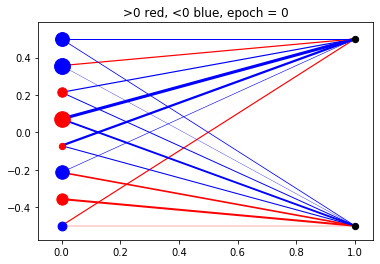

x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1]


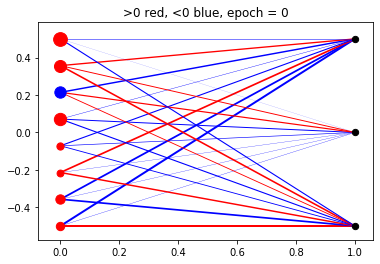

x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1, 1]


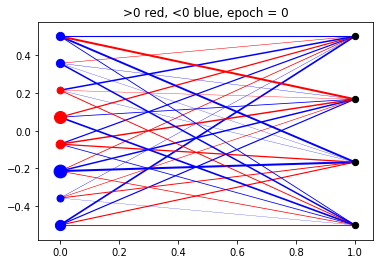

x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1, 1, 1]


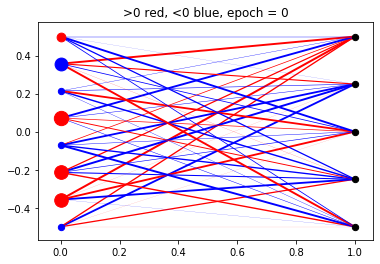

x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1, 1, 1, 1]


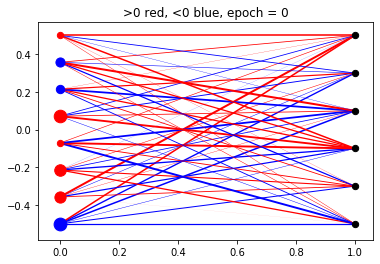

x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1, 1, 1, 1, 1]


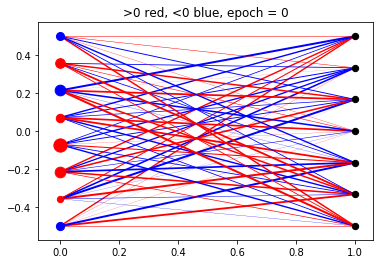

x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1, 1, 1, 1, 1, 1]


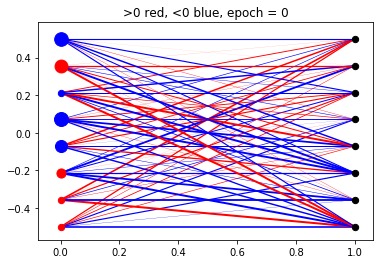

x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1, 1, 1, 1, 1, 1, 1]


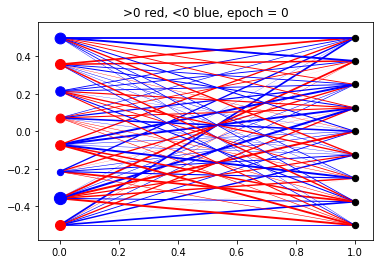

x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


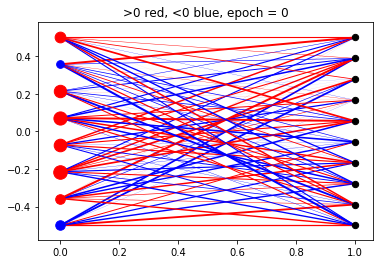

In [35]:
q = 0.1
C=6
fname = 'dataRBM_q' + str(q) + 'C' + str(C) + '.csv'
data = np.loadtxt(fname, delimiter=',', dtype=int)

M = [ i for i in range(2, 11) ] 

sigma = [np.sqrt( 4/ (L + m) ) for m in M]
print('Sigma = ', sigma)

w = [s * (2*np.random.rand(L, m) - 1) for m, s in zip(M, sigma)]
a = [s * (2*np.random.rand(L) - 1) for s in sigma]
b = [np.zeros(m) for m in M] # 0's !

for m in range(len(M)):
    
    (x1,y1) = create_cord(L, 0) # visible
    (x2,y2) = create_cord(M[m], 1) # hidden
    
    def plotgraph_m(m, epoch = 0):
        A = 2/w[m].max() # using weights
        for i in range(L):
            for j in range(M[m]):
                ex, ey, col = (x1[i],x2[j]), (y1[i],y2[j]), mycolor(w[m][i][j])
            # zorder -> scatter plot on top of weights
                plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[m][i][j]))

    # point size
        PS = 400
        PSmin = 40
        for i in range(L):
            plt.scatter(x1[i], y1[i], s=max(PSmin,PS*np.abs(a[m][i])),
                        zorder=2, c=mycolor(a[m][i]))
        for i in range(M[m]):
            plt.scatter(x2[i], y2[i], s=max(PSmin,PS*np.abs(b[m][i])),
                       zorder=2, c=mycolor(b[m][i]))
        plt.title(f'>0 red, <0 blue, epoch = {epoch}')
        plt.show()
     
# ----------- initial configuration
    plotgraph_m(m)

input = [-1  1 -1 -1  1  1 -1 -1]
act = [-0.11737987 -0.51567569]
prob = [0.47068868 0.37386396]
output = [ 1 -1]
input = [-1  1 -1 -1  1  1 -1 -1]
act = [-1.49929634  0.07799386 -0.91483762]
prob = [0.18253049 0.51948859 0.28601093]
output = [-1 -1 -1]
input = [-1  1 -1 -1  1  1 -1 -1]
act = [ 0.10791092  0.64177768 -0.08451235  0.54420368]
prob = [0.52695158 0.6551552  0.47888448 0.63278976]
output = [ 1  1 -1  1]
input = [-1  1 -1 -1  1  1 -1 -1]
act = [-0.43069832 -0.04003303  2.13994988  1.00137808 -1.35962428]
prob = [0.39395959 0.48999308 0.89472589 0.73132944 0.20430137]
output = [-1 -1  1 -1 -1]
input = [-1  1 -1 -1  1  1 -1 -1]
act = [-0.07587263  0.45684526 -0.26313428  0.43620954  0.52311975 -0.76642512]
prob = [0.48104094 0.61226552 0.43459339 0.60735547 0.62787698 0.31725293]
output = [-1 -1  1  1 -1 -1]
input = [-1  1 -1 -1  1  1 -1 -1]
act = [-0.31304184 -1.02811278  2.1296829  -0.16594067 -0.53259086  0.07019966
 -1.2595823 ]
prob = [0.42237243 0.26345015 0.8937549  0.

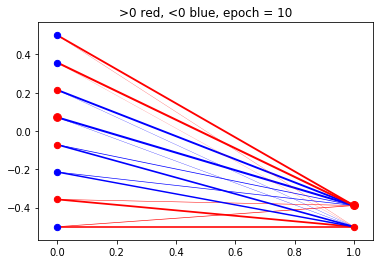

Completed epoch:  11 with l_rate =  0.024390243902439053
Completed epoch:  12 with l_rate =  0.024271844660194202
Completed epoch:  13 with l_rate =  0.024154589371980704
Completed epoch:  14 with l_rate =  0.024038461538461564
Completed epoch:  15 with l_rate =  0.02392344497607658
Completed epoch:  16 with l_rate =  0.023809523809523836
Completed epoch:  17 with l_rate =  0.023696682464455002
Completed epoch:  18 with l_rate =  0.023584905660377384
Completed epoch:  19 with l_rate =  0.02347417840375589
Completed epoch:  20 with l_rate =  0.02336448598130843


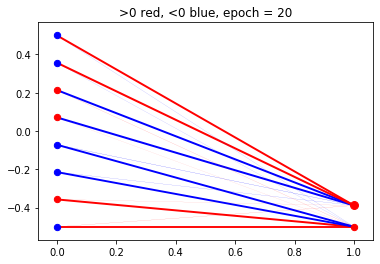

------------ epoch =  1 k =  499 m =  1
dw = [[ 9.30232558e-05  2.60465116e-03 -4.65116279e-03]
 [ 4.74418605e-03  1.67441860e-03 -3.72093023e-03]
 [-2.41860465e-03  4.65116279e-04  1.58139535e-03]
 [ 1.39534884e-03  1.67441860e-03  1.07906977e-02]
 [ 9.30232558e-04  1.95348837e-03 -2.88372093e-03]
 [-3.25581395e-03 -4.83720930e-03 -7.44186047e-04]
 [-1.02325581e-03 -2.79069767e-03  3.72093023e-04]
 [ 4.18604651e-03 -1.11627907e-03  6.69767442e-03]]
da = [-0.00297674 -0.00297674 -0.00102326 -0.00093023 -0.00139535  0.00688372
 -0.00483721 -0.00613953]
db = [ 0.0012093   0.00111628 -0.00130233]
Completed epoch:  1 with l_rate =  0.02325581395348839
------------ epoch =  2 k =  499 m =  1
dw = [[-1.66666667e-03  4.72222222e-03 -3.33333333e-03]
 [ 4.81481481e-03  2.87037037e-03 -3.88888889e-03]
 [-4.72222222e-03 -3.33333333e-03  3.05555556e-03]
 [ 2.31481481e-03 -7.40740741e-04  9.53703704e-03]
 [ 1.11111111e-03  6.48148148e-04 -1.29629630e-03]
 [-3.98148148e-03 -3.33333333e-03  9.2592592

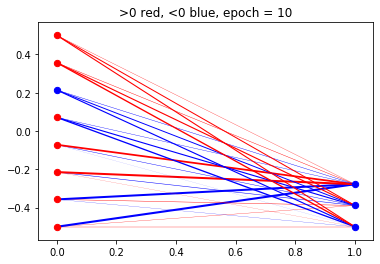

Completed epoch:  11 with l_rate =  0.02222222222222223
Completed epoch:  12 with l_rate =  0.02212389380530974
Completed epoch:  13 with l_rate =  0.022026431718061682
Completed epoch:  14 with l_rate =  0.021929824561403514
Completed epoch:  15 with l_rate =  0.02183406113537119
Completed epoch:  16 with l_rate =  0.02173913043478262
Completed epoch:  17 with l_rate =  0.021645021645021655
Completed epoch:  18 with l_rate =  0.021551724137931046
Completed epoch:  19 with l_rate =  0.02145922746781117
Completed epoch:  20 with l_rate =  0.021367521367521375


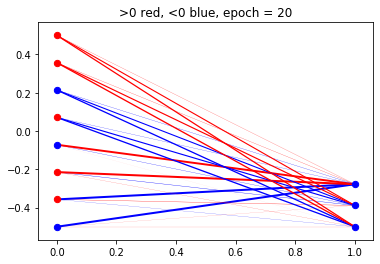

------------ epoch =  1 k =  499 m =  2
dw = [[-0.00059574  0.00348936  0.00212766 -0.00059574]
 [-0.00042553  0.00229787 -0.00348936 -0.00246809]
 [-0.004      -0.00161702  0.00451064  0.00178723]
 [-0.00102128 -0.008      -0.0013617   0.00289362]
 [ 0.00629787  0.00221277 -0.00187234 -0.00119149]
 [ 0.00161702  0.00348936 -0.00331915  0.004     ]
 [ 0.00110638 -0.00246809  0.00348936 -0.00331915]
 [-0.00068085  0.00187234 -0.00068085  0.00017021]]
da = [ 0.00306383  0.00255319  0.00374468 -0.00485106 -0.00331915  0.00034043
  0.00391489  0.00093617]
db = [-8.51063830e-05 -1.44680851e-03 -1.61702128e-03 -4.25531915e-04]
Completed epoch:  1 with l_rate =  0.021276595744680857
------------ epoch =  2 k =  499 m =  2
dw = [[-0.00262712  0.00305085  0.00059322 -0.00127119]
 [ 0.00177966  0.00186441 -0.00110169 -0.00262712]
 [-0.00059322 -0.00152542  0.00194915  0.00059322]
 [ 0.00118644 -0.00652542 -0.00101695  0.00457627]
 [ 0.00415254  0.0020339  -0.00398305 -0.00127119]
 [ 0.00262712  

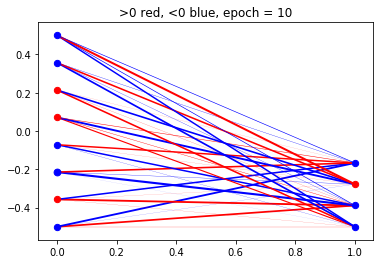

Completed epoch:  11 with l_rate =  0.020408163265306135
Completed epoch:  12 with l_rate =  0.02032520325203253
Completed epoch:  13 with l_rate =  0.020242914979757092
Completed epoch:  14 with l_rate =  0.020161290322580655
Completed epoch:  15 with l_rate =  0.02008032128514057
Completed epoch:  16 with l_rate =  0.020000000000000007
Completed epoch:  17 with l_rate =  0.019920318725099608
Completed epoch:  18 with l_rate =  0.019841269841269847
Completed epoch:  19 with l_rate =  0.01976284584980238
Completed epoch:  20 with l_rate =  0.019685039370078747


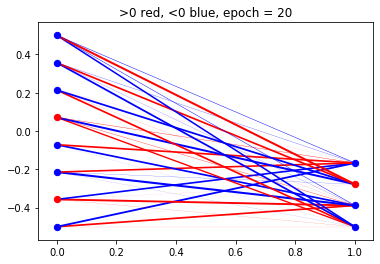

------------ epoch =  1 k =  499 m =  3
dw = [[ 0.00023529  0.00219608  0.00415686  0.00509804 -0.00172549]
 [ 0.0012549   0.00760784 -0.00156863  0.00392157  0.00023529]
 [-0.00164706 -0.00203922 -0.00305882 -0.00070588 -0.00329412]
 [ 0.00415686 -0.00141176 -0.00337255  0.00086275 -0.00235294]
 [-0.00282353 -0.00039216  0.00596078 -0.0012549  -0.00258824]
 [-0.00478431  0.00596078  0.00556863 -0.0014902  -0.00266667]
 [-0.00070588 -0.00156863 -0.00541176  0.00117647 -0.00156863]
 [ 0.00541176  0.00031373 -0.00713725  0.00462745  0.00564706]]
da = [ 0.00015686 -0.00447059 -0.00564706 -0.00015686 -0.00431373  0.00062745
  0.00329412 -0.00298039]
db = [ 7.84313725e-05  1.09803922e-03  1.17647059e-03  2.58823529e-03
 -4.70588235e-04]
Completed epoch:  1 with l_rate =  0.01960784313725491
------------ epoch =  2 k =  499 m =  3
dw = [[ 0.0025      0.00265625  0.00296875  0.0046875   0.00078125]
 [ 0.00078125  0.0059375   0.0015625   0.0034375  -0.00015625]
 [-0.00226563 -0.00132813 -0.002

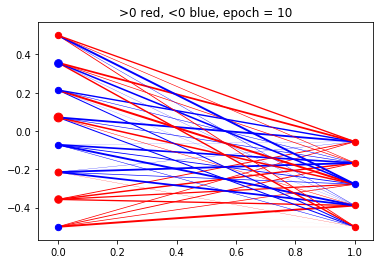

Completed epoch:  11 with l_rate =  0.018867924528301896
Completed epoch:  12 with l_rate =  0.018796992481203017
Completed epoch:  13 with l_rate =  0.018726591760299637
Completed epoch:  14 with l_rate =  0.01865671641791046
Completed epoch:  15 with l_rate =  0.01858736059479555
Completed epoch:  16 with l_rate =  0.01851851851851853
Completed epoch:  17 with l_rate =  0.01845018450184503
Completed epoch:  18 with l_rate =  0.01838235294117648
Completed epoch:  19 with l_rate =  0.018315018315018326
Completed epoch:  20 with l_rate =  0.018248175182481764


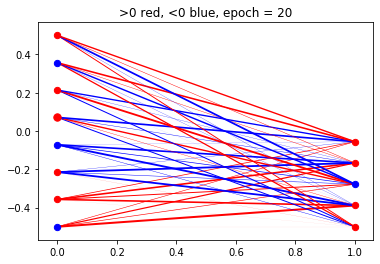

------------ epoch =  1 k =  499 m =  4
dw = [[ 0.0016     -0.00218182 -0.00269091  0.00516364 -0.00043636  0.00116364]
 [ 0.00036364 -0.00385455 -0.0016      0.00203636 -0.0024      0.00094545]
 [-0.0008      0.00225455  0.0064     -0.00087273  0.00167273 -0.00123636]
 [ 0.00450909  0.00378182 -0.00109091  0.00109091  0.00290909 -0.0032    ]
 [-0.00290909  0.00392727 -0.00167273 -0.00647273  0.00450909 -0.00261818]
 [-0.00123636  0.00312727 -0.00087273 -0.00029091  0.00065455 -0.00283636]
 [ 0.00189091 -0.00218182 -0.00283636  0.00196364 -0.00101818  0.00349091]
 [ 0.00436364 -0.00261818 -0.00269091  0.00429091  0.00014545  0.00174545]]
da = [ 2.10909091e-03 -1.30909091e-03 -2.76363636e-03  7.27272727e-05
 -3.41818182e-03  1.01818182e-03  2.83636364e-03 -7.27272727e-05]
db = [-0.00181818 -0.00152727 -0.00014545  0.00029091  0.00050909 -0.00094545]
Completed epoch:  1 with l_rate =  0.018181818181818195
------------ epoch =  2 k =  499 m =  4
dw = [[-0.00014493 -0.00224638 -0.00173913 

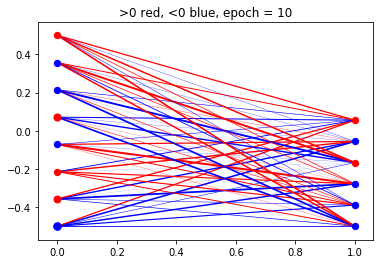

Completed epoch:  11 with l_rate =  0.017543859649122813
Completed epoch:  12 with l_rate =  0.017482517482517487
Completed epoch:  13 with l_rate =  0.01742160278745645
Completed epoch:  14 with l_rate =  0.017361111111111115
Completed epoch:  15 with l_rate =  0.01730103806228374
Completed epoch:  16 with l_rate =  0.017241379310344827
Completed epoch:  17 with l_rate =  0.01718213058419244
Completed epoch:  18 with l_rate =  0.01712328767123288
Completed epoch:  19 with l_rate =  0.017064846416382257
Completed epoch:  20 with l_rate =  0.017006802721088437


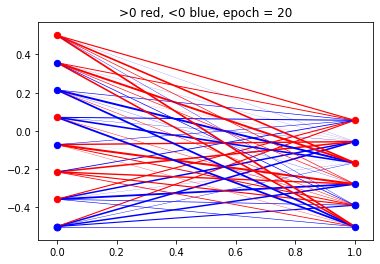

------------ epoch =  1 k =  499 m =  5
dw = [[-0.00088136 -0.00318644  0.00386441  0.00155932 -0.00522034  0.00230508
   0.00013559]
 [ 0.00359322  0.0019661  -0.00264407  0.00128814 -0.00033898  0.0039322
   0.00122034]
 [-0.004      -0.00413559  0.00264407  0.00061017  0.00128814 -0.00040678
  -0.0040678 ]
 [ 0.00054237  0.00338983 -0.00271186 -0.00420339  0.00677966 -0.00074576
   0.00061017]
 [ 0.00155932  0.00101695  0.00237288 -0.00345763  0.0019661   0.00135593
  -0.00162712]
 [-0.00359322 -0.00413559  0.00576271  0.00074576 -0.00291525 -0.00176271
  -0.00447458]
 [-0.0019661  -0.00101695 -0.00359322 -0.00128814 -0.00277966  0.00257627
   0.00528814]
 [-0.00277966 -0.00047458 -0.00169492  0.00088136  0.00074576  0.00040678
   0.00311864]]
da = [ 0.00061017 -0.00088136 -0.00264407 -0.00257627 -0.00155932  0.00183051
 -0.00142373  0.00210169]
db = [ 0.00122034  0.00054237 -0.00067797 -0.00013559  0.00149153  0.00128814
  0.00061017]
Completed epoch:  1 with l_rate =  0.0169491525

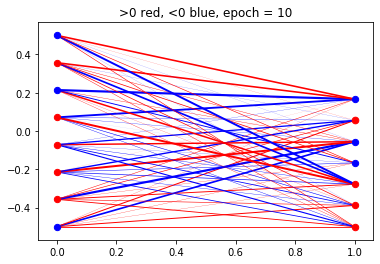

Completed epoch:  11 with l_rate =  0.01639344262295082
Completed epoch:  12 with l_rate =  0.016339869281045753
Completed epoch:  13 with l_rate =  0.016286644951140065
Completed epoch:  14 with l_rate =  0.016233766233766236
Completed epoch:  15 with l_rate =  0.016181229773462785
Completed epoch:  16 with l_rate =  0.016129032258064516
Completed epoch:  17 with l_rate =  0.01607717041800643
Completed epoch:  18 with l_rate =  0.016025641025641024
Completed epoch:  19 with l_rate =  0.01597444089456869
Completed epoch:  20 with l_rate =  0.01592356687898089


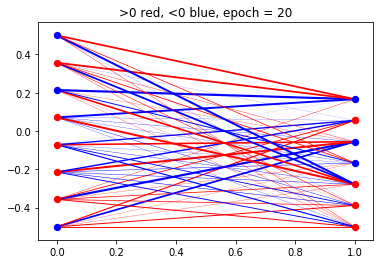

------------ epoch =  1 k =  499 m =  6
dw = [[ 0.00634921  0.00120635  0.00114286  0.00196825  0.00025397  0.00222222
   0.00146032  0.00063492]
 [ 0.00120635  0.00330159  0.00069841  0.0007619  -0.00196825  0.00126984
   0.00165079 -0.00273016]
 [-0.00107937  0.00139683  0.0032381  -0.0024127   0.00044444 -0.00114286
   0.00038095 -0.00196825]
 [-0.00342857  0.00044444 -0.00038095 -0.00222222  0.00228571 -0.0032381
  -0.00298413 -0.00304762]
 [ 0.00209524 -0.00152381  0.00044444  0.00139683  0.00095238  0.
  -0.00368254  0.00450794]
 [-0.00380952  0.00133333  0.00139683 -0.00412698 -0.00038095  0.0032381
  -0.00069841  0.00101587]
 [-0.00133333  0.00114286  0.00412698 -0.00126984 -0.00095238 -0.0007619
   0.00203175 -0.00273016]
 [ 0.00057143  0.          0.00412698  0.00279365 -0.00031746  0.00012698
   0.00342857  0.00069841]]
da = [-0.00031746  0.00101587 -0.00215873  0.00171429  0.00469841 -0.0015873
 -0.0031746   0.00419048]
db = [-1.84126984e-03  1.26984127e-04  3.17460317e-04 

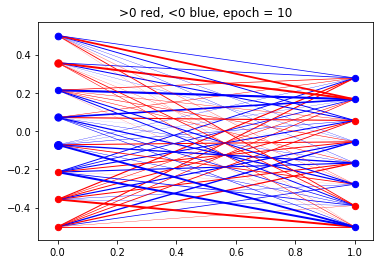

Completed epoch:  11 with l_rate =  0.015384615384615385
Completed epoch:  12 with l_rate =  0.015337423312883437
Completed epoch:  13 with l_rate =  0.015290519877675842
Completed epoch:  14 with l_rate =  0.015243902439024393
Completed epoch:  15 with l_rate =  0.015197568389057756
Completed epoch:  16 with l_rate =  0.015151515151515155
Completed epoch:  17 with l_rate =  0.015105740181268888
Completed epoch:  18 with l_rate =  0.015060240963855427
Completed epoch:  19 with l_rate =  0.01501501501501502
Completed epoch:  20 with l_rate =  0.014970059880239526


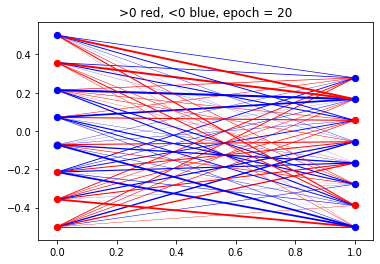

------------ epoch =  1 k =  499 m =  7
dw = [[-1.55223881e-03 -3.82089552e-03  4.53731343e-03  3.22388060e-03
   3.82089552e-03 -1.19402985e-03  8.35820896e-04  3.40298507e-03
  -1.79104478e-04]
 [-2.98507463e-03 -4.41791045e-03  2.74626866e-03 -2.38805970e-04
   2.38805970e-04  2.98507463e-03 -5.97014925e-04  1.13432836e-03
  -2.92537313e-03]
 [ 2.26865672e-03  4.89552239e-03 -1.91044776e-03 -8.35820896e-04
  -2.02985075e-03  2.38805970e-04 -1.19402985e-03 -2.20895522e-03
   4.23880597e-03]
 [-2.98507463e-04  3.52238806e-03 -1.37313433e-03 -1.85074627e-03
   5.97014925e-05  1.97014925e-03  3.40298507e-03 -2.38805970e-03
   4.77611940e-04]
 [ 2.62686567e-03  3.58208955e-04  2.38805970e-03  1.31343284e-03
   1.19402985e-04  9.55223881e-04 -1.67164179e-03 -4.17910448e-04
   1.79104478e-04]
 [ 2.56716418e-03  5.37313433e-04  6.56716418e-04 -7.76119403e-04
  -6.56716418e-04  1.01492537e-03 -1.97014925e-03  3.10447761e-03
  -3.58208955e-04]
 [-1.85074627e-03 -3.16417910e-03 -1.61194030e-03

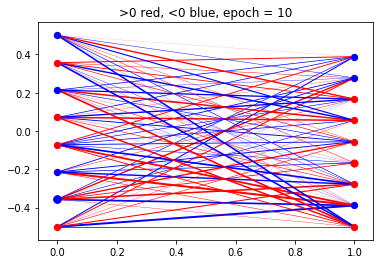

Completed epoch:  11 with l_rate =  0.014492753623188411
Completed epoch:  12 with l_rate =  0.014450867052023126
Completed epoch:  13 with l_rate =  0.014409221902017297
Completed epoch:  14 with l_rate =  0.014367816091954028
Completed epoch:  15 with l_rate =  0.01432664756446992
Completed epoch:  16 with l_rate =  0.014285714285714292
Completed epoch:  17 with l_rate =  0.01424501424501425
Completed epoch:  18 with l_rate =  0.01420454545454546
Completed epoch:  19 with l_rate =  0.014164305949008502
Completed epoch:  20 with l_rate =  0.01412429378531074


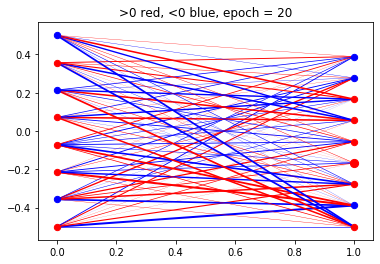

------------ epoch =  1 k =  499 m =  8
dw = [[ 3.88732394e-03  1.01408451e-03  6.76056338e-04  1.12676056e-03
  -1.12676056e-03 -4.00000000e-03 -2.25352113e-04 -2.47887324e-03
  -1.69014085e-04  7.32394366e-04]
 [ 3.43661972e-03  3.15492958e-03 -1.69014085e-03 -1.01408451e-03
   1.01408451e-03 -3.88732394e-03 -7.88732394e-04 -2.70422535e-03
  -6.59154930e-03  5.63380282e-05]
 [-3.54929577e-03 -1.91549296e-03  2.25352113e-03 -1.12676056e-04
  -1.12676056e-04  9.57746479e-04 -1.46478873e-03  2.14084507e-03
   1.18309859e-03  6.19718310e-04]
 [-3.43661972e-03 -1.35211268e-03  3.38028169e-04 -5.63380282e-04
  -7.88732394e-04  3.88732394e-03  1.57746479e-03  3.49295775e-03
   9.57746479e-04 -1.40845070e-03]
 [ 4.05633803e-03 -3.21126761e-03  1.74647887e-03 -2.81690141e-04
  -3.21126761e-03 -2.81690141e-03  5.63380282e-05 -1.40845070e-03
  -1.23943662e-03 -2.36619718e-03]
 [ 1.12676056e-03 -8.45070423e-04 -6.19718310e-04  1.18309859e-03
  -2.76056338e-03  9.01408451e-04  1.29577465e-03  1.6

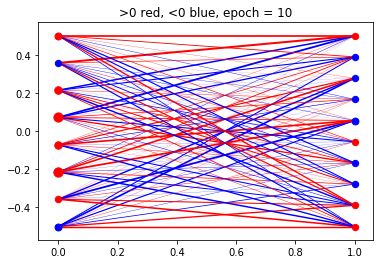

Completed epoch:  11 with l_rate =  0.01369863013698631
Completed epoch:  12 with l_rate =  0.013661202185792356
Completed epoch:  13 with l_rate =  0.013623978201634886
Completed epoch:  14 with l_rate =  0.01358695652173914
Completed epoch:  15 with l_rate =  0.013550135501355023
Completed epoch:  16 with l_rate =  0.013513513513513525
Completed epoch:  17 with l_rate =  0.013477088948787073
Completed epoch:  18 with l_rate =  0.013440860215053776
Completed epoch:  19 with l_rate =  0.013404825737265428
Completed epoch:  20 with l_rate =  0.013368983957219263


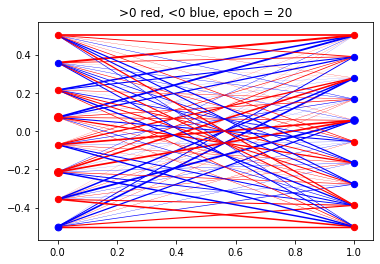

In [36]:
for m in range(len(M)):
    activate(v[k], w[m], b[m], info=True)
mini, mb = 500, 0
# Epochs
max_epoch = 20

for m in range(len(M)):
    # train model
    for epoch in range(1,max_epoch+1):
        # changing l_rate on the fly
        l_rate_m = l_rate / mini

        # scan of data from the catalog
        for k in range(N):
            if mb==0:
                # in the beginning of the minibatch we initialize
                # variables
                # These accumulates statistics during training
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M[m]), np.zeros(M[m])
                vh_data, vh_model = np.zeros((L, M[m])), np.zeros((L, M[m]))

            # positive CD phase: generate h
            h = activate(v[k], w[m], b[m])
            # negative CD phase: generate fantasy vf
            vf = activate(h, w[m].T, a[m]) # note the transpose
            # one more positive CD phase: generate fantasy
            # h from fantasy vf
            hf = activate(vf, w[m], b[m])

            # Accumulate data
            v_data += v[k]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[k].T, h)
            vh_model += np.outer(vf.T, hf)

            # next minibatch
            mb += 1

            # When m == mini, we start the GD
            if mb == mini:
                # gradient od the likelihood: follow it along its positive
                # diretion; Here we use the vanilla GD methos
                # Note: the normalization for the minibatch size is
                # done implicitly in l_rate_m
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)

                # see increments only for small values of epoch and k
                # just to see if GD is stable
                if epoch <= 2 and k <= mini:
                    print('------------ epoch = ', epoch, 'k = ', k,
                         'm = ', m)
                    print(f'dw = {dw}')
                    print(f'da = {da}')
                    print(f'db = {db}')

                # Basic step of vanilla GD, from eq (211)
                w[m] = w[m] + dw
                a[m] = a[m] + da
                b[m] = b[m] + db

                mb = 0
        print('Completed epoch: ', epoch, 'with l_rate = ', l_rate)

        # randomize the order of input data
        np.random.shuffle(v)
        # let the learning rate deacy as epoch^-1
        # this is done the way it is done
        # we need a power law decay, not an exp one
        l_rate = l_rate / (.2 * l_rate + 1)

        # visualization
        if epoch%10 == 0:
            plotgraph_m(m, epoch)

In [37]:
def denoise2(m, temp, save = False):
    '''Returns the number of structured data (i.e. that series which have
    a recognizable pattern) before and after the denoising by producing
    fantasy particles (the model is already trained).
    Moreover, it returns the array of denoised data
    (orininal, denoised, v1) '''
    
    # v1, vector in which save the denoised data
    v1 = np.zeros_like(v0)
    beta = 1./temp
    
    for k in range(N):
        # positive CD phase
        h = activate(v0[k],w[m],b[m],beta)
        # negative CD phase
        v1[k] = activate(h,w[m].T,a[m],beta)
    
    # difference betweeen fantasy and data
    # if elements are equale -> diff = 0
    # otherwise diff != 0
    diff = (v1 - v0)/2
    
    if save:
        str0 = 'M' + str(M[m]) + '-mini' + str(mini) + fname
        np.savetxt('fant-'+str0, (v1+1)/2, fmt = '%d', delimiter=',')
        np.savetxt('diff-'+str0, diff, fmt = '%d', delimiter=',')

    Z = L//4
    vv0 = [0] * Z
    vv1 = [1] * Z
    vv2 = [1, 0]
    case= (vv1 + vv0 + vv1 + vv0,
           vv0 + vv1 + vv1 + vv0,
           vv1 + vv0 + vv0 + vv1,
           vv0 + vv1 + vv0 + vv1,
           vv1 + vv1 + vv1 + vv1,
           vv2 + vv2 + vv2 + vv0)
    
    # Var in which save number of denoise data
    original = 0 # original for a comparison
    denoised = 0
    
    # .all() -> returns true if all elements are true
    for k in range(N):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()
        is4 = (vec1==case[4]).all()
        is5 = (vec1==case[5]).all()
        
        is0_ = (vec0==case[0]).all()
        is1_ = (vec0==case[1]).all()
        is2_ = (vec0==case[2]).all()
        is3_ = (vec0==case[3]).all()
        is4_ = (vec0==case[4]).all()
        is5_ = (vec0==case[5]).all()
        
        # if a structure is recovered, increase denoised
        if (is0 or is1 or is2 or is3 or is4 or is5):
            denoised += 1 
        # This is used to check how many pattern are recognisable
        # in the original data (note elaborated by the RBM)
        if (is0_ or is1_ or is2_ or is3_ or is4_ or is5_):
            original += 1
    
    return (original, denoised, v1)

In [ ]:
# Plotting
T = [0.1, 0.8, 0.95]
(fig, subplots) = plt.subplots(1, len(T) , figsize=(18, 6))

for i in range(len(T)):
    
    n_structured = []
    for m in range(len(M)):
        n_orig, n_den, _ = denoise2(m, T[i])
        n_structured.append(n_den*100/N)
    ax = subplots[i]
    ax.plot(M, n_structured, 'o')
    ax.set_title('fraction of correct denoised data T=%.2f' %T[i], fontsize=fsize)
    ax.set_xlabel('M', fontsize=fsize)
    ax.set_ylabel('% of denoised patterns', fontsize=fsize)
    ax.grid(alpha=0.3)
    ax.plot(M, [n_orig*100/N]*len(M) ,  '--r', lw=1, alpha=0.5)
    #ax.text(2.5, n_orig*100/N - 1, '% of original pattern', color = 'r', fontsize=fsize)
    
plt.show()